# Solving the Time Dependent Schrodinger Equation with Physics-Informed Deep Learning

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.image as img
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from ipywidgets import interact
import ipywidgets as widgets

import warnings
warnings.filterwarnings('ignore')

## <span style="color:Orange">Helper Functions</span>

In [43]:
def viz_colour_rgb(c):
    labels = ['r','g','b','','col']
    
    w = [1,1,1]
    cb = np.zeros((1,5,3))
    cb[0,0,0] = c[0]
    cb[0,1,1] = c[1]
    cb[0,2,2] = c[2]
    cb[0,3,:] = w
    cb[0,4,:] = c

   
    fig = plt.figure(figsize = (5,10))
    ax = fig.add_axes([0,0, 1, 1])  # span the whole figure
    
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="left",
             rotation_mode="anchor")


    ax.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = True, bottom = False)
 
    ax.imshow(cb)
    plt.show()
    print(f"r = {float(c[0]):.2}, g = {float(c[1]):.2}, b = {float(c[2]):.2}")

def viz_colour_predicted_rgb(t,p):
    print("Input RGB:")
    viz_colour_rgb(t)
    print("\nOutput Prediction RGB:")
    viz_colour_rgb(p)
    print("##############################")

rgb_scale = 1.0
cmyk_scale = 1.0

def rgb_to_cmyk(col):
    r,g,b = col
    if (r == 0) and (g == 0) and (b == 0):
        # black
        return 0, 0, 0, cmyk_scale

    # rgb [0,1] -> cmy [0,1]
    c = 1 - r 
    m = 1 - g
    y = 1 - b

    # extract out k [0,1]
    min_cmy = min(c, m, y)
    c = (c - min_cmy) 
    m = (m - min_cmy) 
    y = (y - min_cmy) 
    k = min_cmy

    # rescale to the range [0,cmyk_scale]
    return c*cmyk_scale, m*cmyk_scale, y*cmyk_scale, k*cmyk_scale

def cmyk_to_rgb(col):
    """
    """
    c,m,y,k = col
    r = max(1.0-(c+k),0.0)
    g = max(1.0-(m+k),0.0)
    b = max(1.0-(y+k),0.0)
    return r,g,b

def viz_colour_cmyk(c):
    labels = ['c','m','y','k','','col']
    c = np.asarray(c)
    
    cyan = np.asarray([0,1.0,1.0])
    magenta = np.asarray([1.0,0.0,1.0])
    yellow = np.asarray([1.0,1.0,0.0])
    w = np.asarray([1,1,1])
    
    cyan = np.asarray([1.0,0,0,0])
    magenta = np.asarray([0,1,0,0])
    yellow = np.asarray([0,0,1,0])
    w = np.asarray([1,1,1])
    
    
    rgb_c = cmyk_to_rgb(c)
    cb = np.zeros((1,6,3))
    cb[0,0,:] = cmyk_to_rgb(c[0] * cyan)
    cb[0,1,:] = cmyk_to_rgb(c[1] * magenta)
    cb[0,2,:] = cmyk_to_rgb(c[2] * yellow)
    cb[0,3,:] = (1 - c[3]) * w
    cb[0,4,:] = w
    cb[0,5,:] = rgb_c

   
    fig = plt.figure(figsize = (5,10))
    ax = fig.add_axes([0,0, 1, 1])  # span the whole figure
    #ax.set_axis_off()
    
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="left",
             rotation_mode="anchor")


    ax.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = True, bottom = False)
 
    ax.imshow(cb)
    plt.show()
    print(f"c = {float(c[0]):.2}, m = {float(c[1]):.2}, y = {float(c[2]):.2}, k = {float(c[3]):.2}")

def viz_colour_predicted_cmyk(t,p):
    print("Input RGB:")
    viz_colour_rgb(t)
    print("\nOutput Prediction:")
    viz_colour_cmyk(p)
    print("##############################")

class ColourDataset(Dataset):

    def __init__(self, input_data, output_data, transform=None):
        
        self.input_data = input_data
        self.output_data = output_data
        self.transform = transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = [self.input_data[idx], self.output_data[idx]]


        return sample
debug = False

def get_plots_norm_colorbar(y_true,y_pred, n_x, n_t, x_dom, t_dom, plot_fname):
    labels = ["Predicted", "True", "Abs Err"]
    
    u,v,dens = get_density(y_true.detach().cpu().numpy())
    u_pred, v_pred, dens_pred = get_density(y_pred.detach().cpu().numpy())
    
    

    plot_name = 'TD SE Results' #remove 'network_checkpoint_'
    fig = plt.figure(figsize=(7,8),dpi=100)
    
    mse_u = 0.0
    mse_v = 0.0
    show_cb = False
    cmap = plt.get_cmap('viridis')
    
    x_min = 0
    x_max = 0
    t_min = 0
    t_max = 0
    
    
    u_max = -99.
    u_min = 99.
    v_max = -99.
    v_min = 99.
    d_max = -99.
    d_min = 99.
    
    u_max = np.max((np.max(u),np.max(u_pred)))
    u_min = np.min((np.min(u),np.min(u_pred)))
    v_max = np.max((np.max(v),np.max(v_pred)))
    v_min = np.min((np.min(v),np.min(v_pred)))
    d_max = np.max((np.max(dens),np.max(dens_pred)))
    d_min = np.min((np.min(dens),np.min(dens_pred)))
        
    extent = [x_dom[0] , x_dom[1], t_dom[0] ,t_dom[1]]
    
    u_plot = np.zeros((n_x,n_t))
    v_plot = np.zeros_like((n_x,n_t))
    d_plot = np.zeros_like((n_x,n_t))
    
    reshape_to_grid = lambda x: np.reshape(x,  (n_x, n_t))
    
    for i in np.arange(3):
        if i==0:
            u_plot = reshape_to_grid(u_pred)
            v_plot = reshape_to_grid(v_pred)
            d_plot = reshape_to_grid(dens_pred)
            show_cb = False
        if i==1:
            u_plot = reshape_to_grid(u)
            v_plot = reshape_to_grid(v)
            d_plot = reshape_to_grid(dens)
        if i == 2:
            u_plot = np.abs(reshape_to_grid(u - u_pred))
            v_plot = np.abs(reshape_to_grid(v - v_pred))
            d_plot = np.abs(reshape_to_grid(dens_pred - dens))
            show_cb = True


        ax1 = fig.add_subplot(3,3,i+1)
        ims = ax1.imshow(u_plot, extent=extent,vmin=u_min, vmax=u_max)
        ax1.set_title(fr"{labels[i]} Re($\psi$)")
        ax1.set_xlabel(r'$x$')
        ax1.set_ylabel(r'$t$')
        if show_cb:
            divider = make_axes_locatable(ax1)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            norm = mpl.colors.Normalize(vmin=u_min, vmax=u_max)
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            fig.colorbar(sm, cax=cax)
            
        ax1 = fig.add_subplot(3,3,i+4)
        ax1.set_title(fr"{labels[i]} Im($\psi$)")
        ims = ax1.imshow(v_plot, extent=extent,vmin=v_min, vmax=v_max)
        ax1.set_xlabel(r'$x$')
        ax1.set_ylabel(r'$t$')
        if show_cb:
            divider = make_axes_locatable(ax1)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            norm = mpl.colors.Normalize(vmin=v_min, vmax=v_max)
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            fig.colorbar(sm, cax=cax)
            
        ax1 = fig.add_subplot(3,3,i+7)
        ax1.set_title(fr"{labels[i]} $|\psi|^2$")
        ims = ax1.imshow(d_plot, extent=extent,vmin=d_min, vmax=d_max)
        ax1.set_xlabel(r'$x$')
        ax1.set_ylabel(r'$t$')
        if show_cb:
            divider = make_axes_locatable(ax1)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            norm = mpl.colors.Normalize(vmin=d_min, vmax=d_max)
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            fig.colorbar(sm, cax=cax)
        
        if i==2:
            mse_u = np.mean(u_plot**2)
            mse_v = np.mean(v_plot**2)
            
        print(f"{i} finished")
            
    plot_title = plot_name
    plt.suptitle(fr"{plot_title}",y=0.92)
    plt.savefig(f'./tmp_data/{plot_fname}')
    plt.show()
    print(f"mse: u: {mse_u}, v:{mse_v}")
    return mse_u,mse_v

def get_density(y_pred):
# Helper function to split data into real, imag, density
    u = y_pred[:,0]
    v = y_pred[:,1]
    dens = u**2 + v**2
    
    return u,v,dens

def get_waveforms(analytical_solution_function):
    
    L = float(np.pi)
    omega = 1
    delta_T = 0.1
    delta_X = 0.1
    x_dom = [-L,L]
    t_dom = [0, 2*L]

    x = np.arange(x_dom[0], x_dom[1], delta_X).astype(float)
    t = np.arange(t_dom[0], t_dom[1], delta_T).astype(float)
    X, T = np.meshgrid(x, t)
    
    psi_val = analytical_solution_function(X,T,omega)
    u = np.real(psi_val)
    v = np.imag(psi_val)
    
    dens = u**2 + v**2
    max_d = np.max(dens)+0.02
    
    
    
    for t_step in range(len(t)):
        curr_u = u[t_step,:]
        curr_v = v[t_step,:]
        curr_d = dens[t_step,:]
        
        fig, ax = plt.subplots()
        plt.ylim(0.0,max_d)
        ax.plot(x, curr_d)
        
        ax.set(xlabel='x (au)', ylabel=r'Probability Density $|\psi(x)|^2$',
               title=fr'$|\psi(x)|^2$ at t={t[t_step]:.2f} au')
        ax.grid()

        fig.savefig(f"tmp_data/waveform/t_{str(t_step).zfill(2)}.png")
        plt.show()

    return None

In [44]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

torch.set_default_dtype(torch.double)
#torch.set_default_device('cuda:0')
torch.set_default_device('cpu')


cpu


## <span style="color:Orange">Brief Overview</span>

The Time-Independent Schrödinger Equation is a fundamental equation in quantum mechanics that describes how the quantum state of a physical system changes in space, but not in time. It is derived from the more general Time-Dependent Schrödinger Equation (TDSE) under the assumption that the system is in a steady state, meaning the potential energy within the system does not change with time. The TISE is crucial for understanding the behavior of particles in potential wells, quantum tunneling, and the quantization of energy levels in atoms and molecules.

### <span style="color:LightGreen">Mathematical Formulation</span>

The Time-Independent Schrödinger Equation can be introduced starting from the fundamental relationship involving the Hamiltonian operator $ \hat{H} $ acting on the wave function $ \psi $, equating it to the energy $ E $ of the system times the wave function. This is expressed as:

$$ \Large
\hat{H} \psi = E \psi
$$

The Hamiltonian operator $ \hat{H} $ represents the total energy of the system and is composed of the kinetic energy ($ T $) and potential energy ($ V $) operators:

$$ \Large
\hat{H} = \hat{T} + \hat{V}
$$

where the kinetic energy operator $ \hat{T} $ is given by:

$$ \Large
\hat{T} = -\frac{\hbar^2}{2m} \nabla^2
$$

and $ \hat{V} $ represents the potential energy operator, which in position space is simply multiplication by the potential energy function $ V(\mathbf{r}) $:

$$ \Large
\hat{V} = V(\mathbf{r})
$$

Substituting the expressions for $ \hat{T} $ and $ \hat{V} $ into the Hamiltonian, we obtain the Time-Independent Schrödinger Equation in position space:

$$ \Large
\left( -\frac{\hbar^2}{2m} \nabla^2 + V(\mathbf{r}) \right) \psi(\mathbf{r}) = E\psi(\mathbf{r})
$$

Here:
- $ \hbar $ is the reduced Planck's constant ($ \hbar = \frac{h}{2\pi} $),
- $ m $ is the mass of the particle,
- $ \nabla^2 $ is the Laplacian operator, indicating the second spatial derivatives,
- $ \psi(\mathbf{r}) $ is the wave function of the particle, a complex function that provides information about the probability amplitude of the particle's position,
- $ V(\mathbf{r}) $ is the potential energy as a function of position,
- $ E $ is the total energy of the system, which is a constant for time-independent systems.

### <span style="color:LightGreen">Physical Interpretation</span>

The Time-Independent Schrödinger Equation is an eigenvalue equation where the eigenvalues $ E $ correspond to the energy levels of the system, and the eigenfunctions $ \psi(\mathbf{r}) $ represent the stationary states. The probability density of finding the particle at a given position $ \mathbf{r} $ is given by the square modulus of the wave function, $ |\psi(\mathbf{r})|^2 $.

## <span style="color:Orange">Infinite Square Well</span>

The infinite square well (or particle in a box) is a fundamental quantum mechanical system that provides profound insights into the quantization of energy. In this model, a particle is confined to a one-dimensional box with infinitely high walls, leading to discrete energy levels. The potential $V(x)$ can be described as:

$$ \Large
V(x) = \begin{cases}
0, & \text{if } 0 \leq x \leq L\\
\infty, & \text{otherwise}
\end{cases}
$$

where $L$ is the width of the well. For the region inside the well ($0 \leq x \leq L$), the TISE simplifies to:

$$ \Large
-\frac{1}{2} \frac{d^2}{dx^2} \psi(x) = E\psi(x)
$$

### <span style="color:LightGreen">Analytic Solution</span>

The boundary conditions dictate that $\psi(x) = 0$ at $x = 0$ and $x = L$, leading to quantized energy levels. The solutions to the TISE in this case are sinusoidal functions inside the well:

$$ \Large
\psi_n(x) = \sqrt{\frac{2}{L}} \sin\left(\frac{n\pi x}{L}\right), \quad n = 1, 2, 3, \ldots
$$

The corresponding energy levels are given by:

$$ \Large
E_n = \frac{n^2\pi^2}{2L^2}, \quad n = 1, 2, 3, \ldots
$$

Let us implement the potential and analytical solution:

In [45]:
# Exercise

def V_infinite_well(x, params):
    L = params
    return np.zeros_like(x)

def analytical_eigenvalues_infinite_well(n, params):
    n = n + 1 # avoiding trivial solution
    L = params
    E = (n * np.pi / L)**2/2
    return E

def analytical_eigenfunctions_infinite_well(x, n, params):
    n = n + 1 # avoiding trivial solution
    L = params
    psi = np.sqrt(2 / L) * np.sin(n * np.pi * x / L)
    return normalize_wavefunction(psi, x)

### <span style="color:LightGreen">Setting up TISE Solver</span>

We take a short detour to study a simple numerical method to get the derivates. It is called the Finite Difference Method. 

We know that first derivative of a function $f(x)$ at a point $x$ represents the rate at which $f(x)$ changes with respect to $x$. The first derivative is defined as the limit of the average rate of change of the function as the interval over which the change is measured approaches zero. Mathematically, this is expressed as:

$$ \Large
f'(x) = \lim_{h \to 0} \frac{f(x+h) - f(x)}{h}
$$

where $h$ is the difference between the neighboring point $x+h$ and the point $x$, and $f(x+h) - f(x)$ represents the change in the function's value over that interval. The expression $\frac{f(x+h) - f(x)}{h}$ calculates the average rate of change of $f(x)$ over the interval from $x$ to $x+h$.

The approximation of the first derivative works based on the principle of this definition. In practice, we cannot take the limit as $h$ goes to zero because that would require infinitesimally small steps, which are not possible to handle with numerical computations. Instead, we choose a small but finite value of $h$, which allows us to approximate the instantaneous rate of change (the derivative) by calculating the slope of the secant line that passes through the points $(x, f(x))$ and $(x+h, f(x+h))$.

So, we have

$$ \Large
f'(x_i) \approx \frac{f(x_{i+1}) - f(x_i)}{h}
$$

for a finite $h$. This formula gives a first-order approximation of the derivative.

Let's implement this in python for an arbitrary function `f` at grid points `x_grid`


In [46]:
# Exercise: Get the first derivative numerically
def approximate_first_derivative(f, x_grid):
    dfdx = np.zeros_like(x_grid)
    
    # Compute the spacing based on the input grid
    # Assuming uniform spacing
    h = x_grid[1] - x_grid[0]
    
    # Forward difference for all points except the last
    dfdx[:-1] = (f(x_grid[1:]) - f(x_grid[:-1])) / h
    
    # This is provided to make sure that the last point is not left out.
    # Since we don't have a forward difference for the last point, we'll use a backward difference.
    # It is similar to the forward difference, but we use the previous point instead of the next point.
    dfdx[-1] = (f(x_grid[-1]) - f(x_grid[-2])) / h
    
    return dfdx

In [47]:
def test_derivative(k):
    x_min = 0
    x_max = 10
    N = (x_max - x_min)/10**k + 1
    x = np.linspace(0, 10, int(N))

    f = np.sin

    dfdx_approx = approximate_first_derivative(f, x)

    dfdx_exact = np.cos(x)

    plt.figure(figsize=(10, 6))
    plt.plot(x, dfdx_approx, label='FDM Derivative', marker='o', linestyle='--')
    plt.plot(x, dfdx_exact, label='Analytical Derivative', alpha=0.7)
    plt.xlabel('x')
    plt.ylabel('df/dx')
    plt.title(f'Approximation vs. Analytical Derivative of $f(x) = sin(x)$, h = {x[1]-x[0]}')
    plt.legend()
    plt.show()

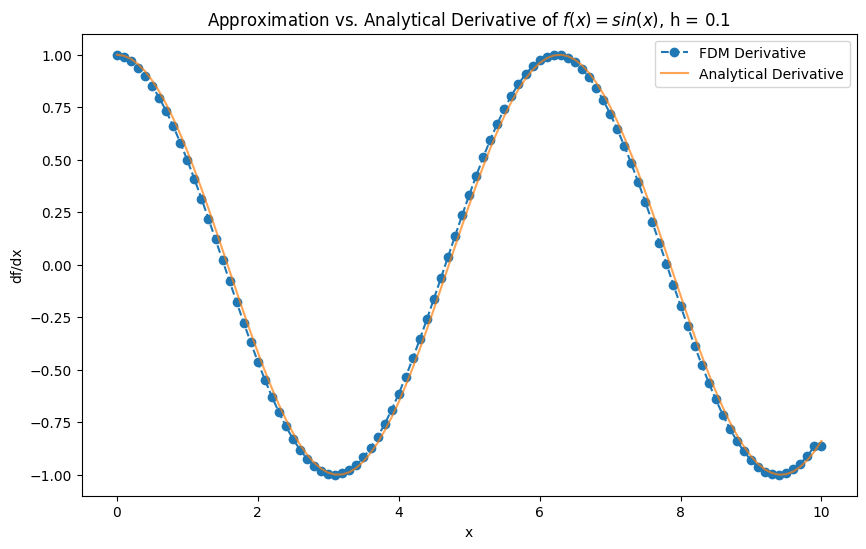

In [48]:
test_derivative(-1)

To approximate the second derivative, we start from the basic first derivative approximations and extend them. The second derivative at a point $x_i$ can be derived by applying the first derivative approximation twice, leading to:

$$
f''(x_i) \approx \frac{f'(x_{i+1}) - f'(x_i)}{h}
$$

Exercise: Use the forward difference formula for $f'(x_{i+1})$ and $f'(x_i)$ and simplify the above equation to get:

$$
f''(x_i) \approx \frac{f(x_{i+1}) - 2f(x_i) + f(x_{i-1})}{h^2}
$$

This gives us a second-order accurate approximation of the second derivative.

Notice that x grid is a vector of length $N+1$. We can represent this as a matrix multiplication

$$
F2X = FD2 * f(x)
$$
where f(x) is the vector of legth $N+1$, and FD2 is a matrix of shape $N+1, N+1$ with diagonal elements corresponding to the terms in the finite difference equation you derived above. Let's implement this in code:

In [49]:
# Exercise

def get_fd2_matrix(x_grid, fix_boundary=False):
    # Define the matrix
    N = len(x_grid)
    h = x_grid[1] - x_grid[0]

# Main diagonal values (central differences for the second derivative)
    main_diagonal = -2.0 * np.ones(N) / h**2
    
    # Off diagonal values (one step off the main diagonal)
    off_diagonal = 1.0 * np.ones(N - 1) / h**2
    
    # Assemble the tridiagonal matrix
    fd_matrix = np.diag(main_diagonal) + np.diag(off_diagonal, 1) + np.diag(off_diagonal, -1)

    # These are for numerical stability. We use higher order terms at the boundaries.
    if fix_boundary:
        if N > 4:
            fd_matrix[0, :4] =  [2, -5, 4, -1] / h**2
            fd_matrix[-1, -4:] = [-1, 4, -5, 2] / h**2
        else:
            raise ValueError("The grid is too small to use higher order terms.")
            
    return fd_matrix


This is what the matrix looks like:

In [50]:
mat = get_fd2_matrix(np.arange(0,5,1)/1)
print(mat)

[[-2.  1.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.]
 [ 0.  1. -2.  1.  0.]
 [ 0.  0.  1. -2.  1.]
 [ 0.  0.  0.  1. -2.]]


Do you notice the [1, -2, 1] pattern from our derivation?

Now we use this matrix on our test problem sin(x)

In [51]:
def test_second_derivative(k, show_boundary=False, fix_boundary=False):
    x_min = 0
    x_max = 6.28
    N = (x_max - x_min)/10**k + 1
    x = np.linspace(x_min, x_max, int(N))

    f = np.sin(x)
    mask = np.arange(len(x))

    if not show_boundary:
        mask = mask[1:-1]

    fd_matrix = get_fd2_matrix(x, fix_boundary=fix_boundary)

    df2dx2_approx = fd_matrix @ f


    dfdx_exact = -np.sin(x)
    # print(f"{k=}, {show_boundary=}")
    plt.figure(figsize=(10, 6))
    plt.plot(x[mask], df2dx2_approx[mask], label='FDM Derivative', marker='o', linestyle='--')
    plt.plot(x[mask], dfdx_exact[mask], label='Analytical Derivative', alpha=0.7)
    plt.xlabel('x')
    plt.ylabel('df/dx')
    plt.title(f'Approximation vs. Analytical Derivative of $f(x) = sin(x)$, h = {x[2]-x[1]:.3}, 10^k={10**k}')
    plt.legend()
    plt.show()

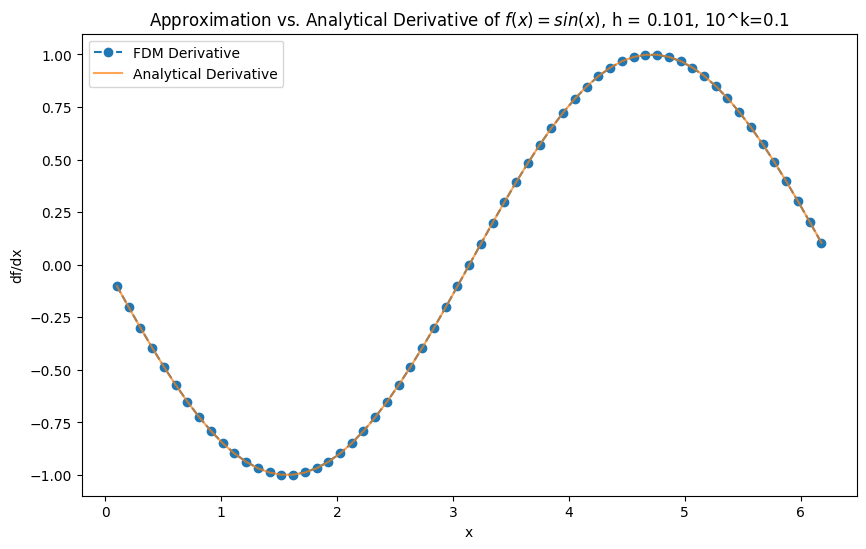

In [52]:
test_second_derivative(-1)

The second derivative in the kinetic energy term can be approximated using the central difference formula:

$$ \Large
\frac{d^2\psi}{dx^2} \bigg|_{x_i} \approx \frac{\psi(x_{i+1}) - 2\psi(x_i) + \psi(x_{i-1})}{h^2}
$$

Substituting this into the TISE, we get a discrete version:

$$ \Large
-\frac{1}{2} \frac{\psi(x_{i+1}) - 2\psi(x_i) + \psi(x_{i-1})}{h^2} + V(x_i)\psi(x_i) = E\psi(x_i)
$$

This leads to a system of linear equations that can be represented in matrix form as $H\vec{\psi} = E\vec{\psi}$, where $H$ is a tridiagonal matrix with the diagonal elements given by $\left(\frac{1}{h^2} + V(x_i)\right)$ and the off-diagonal elements by $-\frac{1}{2h^2}$.

Now this eigenvalue problem can be solved by matrix inversion methods that you learnt about in your Linear Algebra course. We will use the built-in `np.linalg.eigh` function to get the eigenvalues and eigenvectors. The function takes a potential function `V` and its `params`.

In [53]:
# Utility: Normalize wavefunction

def normalize_wavefunction(psi, x):
    density = np.conj(psi) * psi
    integral_density = np.trapezoid(density, x)
    return psi/np.sqrt(integral_density)



In [54]:
# Exercise: Use the functions we defined to set up a TISE solver
def solve_tise(V, params, x_min, x_max, N, state_n=0):
    # Discretize the spatial domain
    x = np.linspace(x_min, x_max, N)
    
    # Evaluate the potential energy
    V_x = V(x, params)
    
    # Assemble the Hamiltonian matrix
    T_mat = get_fd2_matrix(x)
    V_mat = np.diag(V_x)

    H_mat = -0.5 * T_mat + V_mat
    
    # Solve the eigenvalue problem
    E, psi = np.linalg.eigh(H_mat)
    E = E[state_n]
    psi = psi[:, state_n]
    
    # Normalize the wavefunction
    psi = normalize_wavefunction(psi, x)
        
    return x, E, psi


In [55]:
# Utility: Plotting the wavefunction
def wavefunction_plotter(V, params, x_min, x_max, N, state_n=0, true_wavefunction_fn=None, true_energy_fn=None, sys_name="System"):
    x, E, psi = solve_tise(V, params, x_min, x_max, N, state_n)
    if true_wavefunction_fn is not None and true_energy_fn is not None:
            true_E = true_energy_fn(state_n, params)
            true_wfs = true_wavefunction_fn(x, state_n, params)
            
            # Normalize the wavefunction
            true_density = np.conj(true_wfs) * true_wfs
            integral_density = np.trapezoid(true_density, x)
            true_wfs = true_wfs/ np.sqrt(integral_density)

            
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7.5, 9))

    ax1.plot(x, psi, label=f'E_{state_n} = {E:.2f}')
    if true_wavefunction_fn is not None and true_energy_fn is not None:
        ax1.plot(x, true_wfs, label=f'True E_{state_n} = {true_E:.2f}', linestyle='--')
    ax1_right = ax1.twinx()
    ax1_right.plot(x, V(x, params), label='V(x)', color='black')
    ax1_right.set_ylabel('V(x)')
    ax1.set_xlabel('x')
    ax1.set_ylabel(r'$\psi(x)$')
    ax1.set_title(f'Wavefunction for {sys_name}, state {state_n}')
    ax1.legend(loc='upper left')
    ax1_right.legend(loc='upper right')

    density = np.conj(psi) * psi

    ax2.plot(x, density, label=r'Density |$\psi$|^2')
    
    if true_wavefunction_fn is not None and true_energy_fn is not None:    
        ax2.plot(x, true_density, label=r'True Density |$\psi$|^2', linestyle='--')
    ax2_right = ax2.twinx()
    ax2_right.plot(x, V(x, params), color='black')
    ax2_right.set_ylabel('V(x)')
    ax2.set_xlabel('x')
    ax2.set_ylabel(r'|$\psi(x)$|^2')
    ax2.set_title(f'Density for {sys_name}, state {state_n}')
    ax2.legend(loc='upper left')
    ax2_right.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


Now let us solve it with our numerical solver:

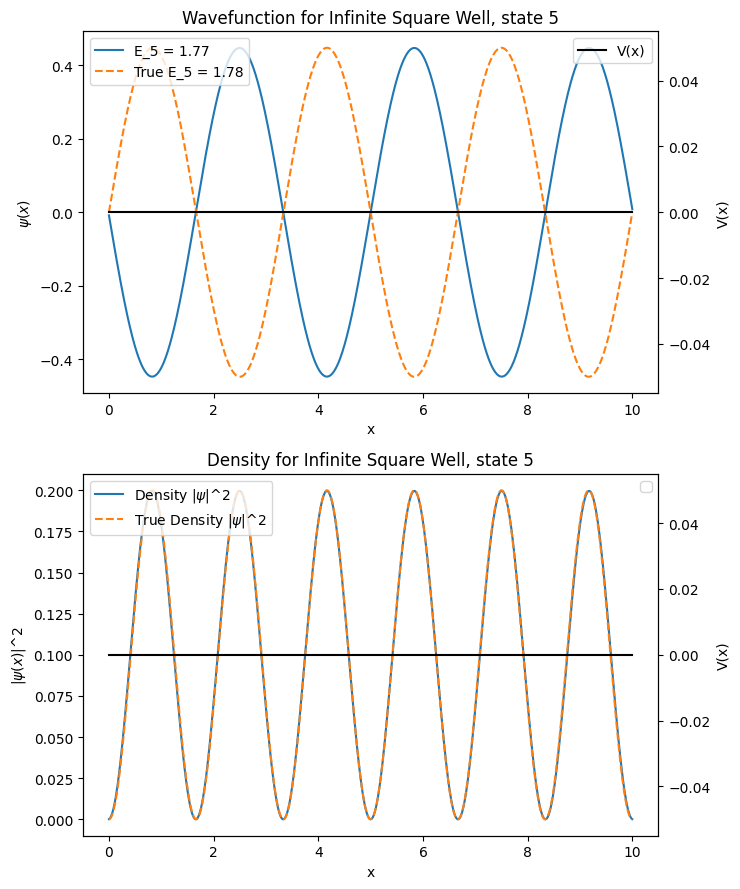

In [56]:
L = 10
x_min = 0
x_max = L
N = 1001
V = V_infinite_well
params = L
n_state = 5
true_wavefunction_fn=analytical_eigenfunctions_infinite_well
true_energy_fn=analytical_eigenvalues_infinite_well
sys_name = "Infinite Square Well"

wavefunction_plotter(V, params, x_min, x_max, N, n_state, true_wavefunction_fn=true_wavefunction_fn, true_energy_fn=true_energy_fn, sys_name=sys_name)

In [57]:
state_n_slider = widgets.IntSlider( value=0, min=0, max=10, step=1, description='state_n:', continuous_update=False)

def interactive_wavefunction_plotter(state_n):
    wavefunction_plotter(V, params, x_min, x_max, N, state_n, true_wavefunction_fn, true_energy_fn, sys_name)

interactive_plot = widgets.interactive(interactive_wavefunction_plotter, state_n=state_n_slider)
display(interactive_plot)

interactive(children=(IntSlider(value=0, continuous_update=False, description='state_n:', max=10), Output()), …

## <span style="color:Orange">Quantum Harmonic Oscillator (Time Independent)</span>

The quantum harmonic oscillator models a particle moving under a restoring force proportional to its displacement from a equilibrium position, akin to a mass on a spring. The potential energy $V(x)$ of the QHO is given by:

$$ \Large
V(x) = \frac{1}{2}\omega^2x^2
$$

where $m$ is the mass of the particle, $\omega$ is the angular frequency of the oscillator, and $x$ is the displacement from equilibrium. In quantum mechanics, the TISE for the harmonic oscillator becomes:

$$ \Large
\left( -\frac{1}{2} \frac{d^2}{dx^2} + \frac{1}{2}\omega^2x^2 \right) \psi(x) = E\psi(x)
$$

### <span style="color:LightGreen">Analytic Solution</span>

The solutions to the quantum harmonic oscillator are Hermite polynomials multiplied by a Gaussian exponential. The energy eigenvalues are given by:

$$ \Large
E_n = \left(n + \frac{1}{2}\right)\omega, \quad n = 0, 1, 2, \ldots
$$

The analytical solution $\psi(x,t) \in \mathbb{C}$ is
$$ \Large
\psi_0(x) = \sqrt[4]{\frac{\omega}{\pi}}e^{\left(-\frac{\omega x^2}{2}\right)}
$$

and

$$ \Large
\psi_n(x) = \psi_0(x) \frac{1}{\sqrt{2^n n!}}Her_n(\sqrt{\omega}x)
$$

where $Her_n$ are the Hermite polynomials of degree $n$.

Let us implement the potential:

In [58]:
# Exercise
def V_harmonic_oscillator(x, params):
    omega = params
    v = 0.5 * omega**2 * x**2
    return v

To implement the analytical solution, we need to first implement Hermite polynomials. We will use the recursive definition:
- $H_0(x) = 1$
- $H_1(x) = 2x$
- $H_{n+1}(x) = 2xH_n(x) - 2nH_{n-1}(x)$ for $n \geq 1$

Let's implement this recursive definition:

In [59]:
# Exercise: Use the above recursive relation to calculate the Hermite polynomials
def hermite_polynomial(n, x):

    if n == 0:
        return np.ones_like(x)
    elif n == 1:
        return 2 * x
    else:
        return 2 * x * hermite_polynomial(n - 1, x) - 2 * (n - 1) * hermite_polynomial(n - 2, x)


In [60]:
# Exercise
def analytical_eigenvalues_harmonic_oscillator(n, params):

    omega = params
    E = (n + 0.5) * omega
    return E

def analytical_eigenfunctions_harmonic_oscillator(x, n, params):
    
    omega = params

    psi_0 = (omega/np.pi)**0.25 * np.exp(-0.5 * omega * x**2)
    
    if n > 0:
        prefactor = 1 / np.sqrt(2**n * factorial(n))
        hermite_polynomial_n = hermite_polynomial(n, np.sqrt(omega) * x)
        psi = prefactor * hermite_polynomial_n * np.exp(-0.5 * omega * x**2)    
        return normalize_wavefunction(psi, x)
    else:
        return normalize_wavefunction(psi_0, x)

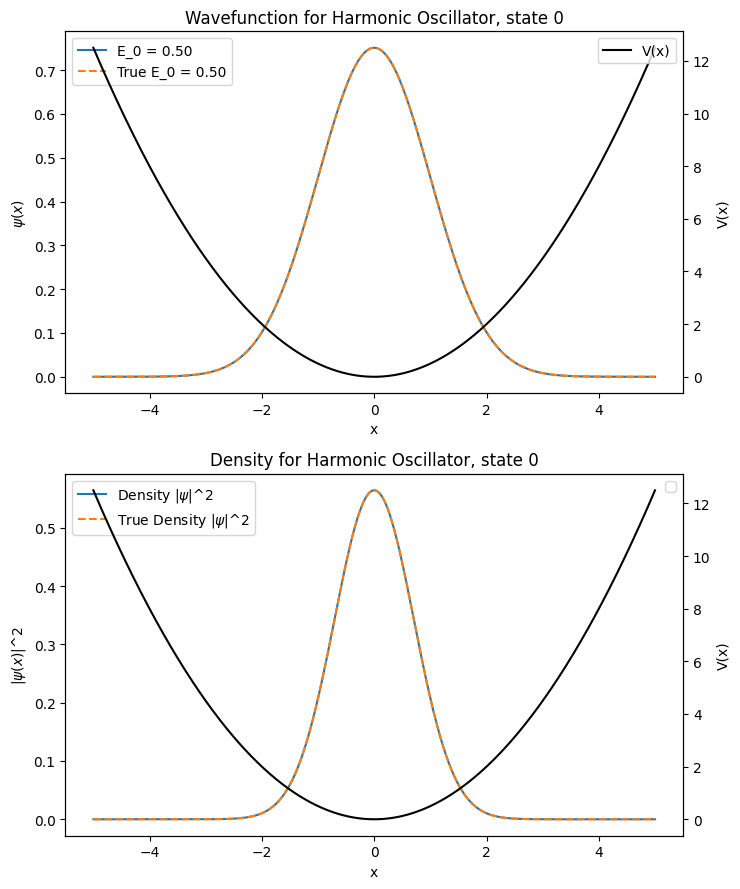

In [61]:
wavefunction_plotter(V_harmonic_oscillator, 1, -5, 5, 1001, 0, analytical_eigenfunctions_harmonic_oscillator, analytical_eigenvalues_harmonic_oscillator, "Harmonic Oscillator")

## <span style="color:Orange">Quantum Harmonic Oscillator (Time Dependent)</span>

Next, we want to solve a Quantum Harmonic Oscillator consisting of a superposition of two states. Note: We will use atomic units unless specified: $\hbar=m=e=1$. 

The governing equation is time-dependent Schrödinger equation

$$ \Large
i \frac{\partial \psi(\mathbf{r}, t)}{\partial t}-\hat{H} \psi(\mathbf{r}, t)=0
$$

for a quantum harmonic oscillator consisting of the superposition of two eigenstates $m,n$. In the one-dimensional case, the Hamiltonian is

$$ \Large
\hat{H_x}=-\frac{1}{2}\frac{\partial^{2}}{\partial x^{2}}+\frac{\omega^{2}}{2}x^{2}
$$

The analytical solution $\psi(x,t) \in \mathbb{C}$ is

$$ \Large
\phi_0(x) = \sqrt[4]{\frac{\omega}{\pi}}e^{\left(-\frac{\omega x^2}{2}\right)}
$$

$$ \Large
\phi_1(x) = \phi_0(x) \sqrt{2\omega}x
$$

For higher states,

$$ \Large
\phi_n(x) = \phi_0(x) \frac{1}{\sqrt{2^n n!}}Her_n(\sqrt{\omega}x)\exp\left(-i E_n t\right)
$$

where $Her_n(\sqrt{\omega}x)$ is the $n^{\rm th}$ Hermite polynomial, and phase $\exp\left(-i E_n t\right)$ where $E_n = (n+\frac{1}{2})\omega$

The superposition is defined as

$$ \Large
\psi_{m,n}(x,t) = \frac{1}{\sqrt{2}}\left( e^{\left(-i E_m t\right)}\phi_m(x) + e^{\left(-i E_n t\right)}\phi_n(x)\right)
$$

### <span style="color:LightGreen">Base case:</span> $\psi_{0,1}(x,t)$

Let's derive the analytical solution for $\psi_{0,1}(x,t)$.

$$ \Large
\psi_{0,1}(x,t) = \frac{1}{\sqrt{2}}\left( e^{\left(-i E_0 t\right)}\phi_m(x) + e^{\left(-i E_1 t\right)}\phi_n(x)\right)
$$

The $n^{\rm th}$ Physicist's Hermite Polynomial is defined as:

$$ \Large
H_{n}(y)=(-1)^{n} e^{y^{2}} \frac{d^{n}}{d y^{n}} e^{-y^{2}}
$$

Now that we have our analytical solution, let's write some code to compute it for arbitrary values of $x,t,\omega$

In [62]:
def get_analytical_solution_base(X,T,omega):
    # Analytical solution for first two states. X,T are numpy arrays, omega is a float.
    # Hint: Avoid using for loops, use numpy functions to calculate the wavefunction.
    
    #Solution:
    phi_0 = (omega / np.pi) ** (1. / 4.) * np.exp(-X * omega * X / 2.0)
    phi_1 = phi_0 *  np.sqrt(omega / 2.) * 2.0 * X
    psi = np.sqrt(1. / 2.) * (np.exp(-1j * omega/2 * T) * phi_0 + np.exp(-1j* 3/2 * omega * T) * phi_1)

    return psi

Let's define the domain for our problem:

We will restrict our domain to $\mathbf{x} \in [-\pi,\pi], t \in [0,T]$, with fixed boundary conditions $x_0, x_b = 0$ in this notebook. 

After you go through the notebook, feel free to play with the code for other domains. Let's create some data using the function we just wrote.

In [63]:
def get_data_set(x_dom, t_dom, delta_X, delta_T, omega, analytical_solution_fun):
    # Helper function to generate datasets from analytical solutions.
    

    x = np.arange(x_dom[0], x_dom[1], delta_X).astype(float)
    t = np.arange(t_dom[0], t_dom[1], delta_T).astype(float)
    X, T = np.meshgrid(x, t)

    X = np.expand_dims(X.flatten(), axis=-1)
    T = np.expand_dims(T.flatten(), axis=-1)

    psi_val = analytical_solution_fun(X,T,omega)
    u = np.real(psi_val)
    v = np.imag(psi_val)

    train_input = np.hstack((X,T))
    train_output = np.hstack((u,v))

    train_x = torch.tensor(train_input).to(device)
    train_y = torch.tensor(train_output).to(device)

    return train_x, train_y

In [64]:
# Define domain in code

L = float(np.pi)
omega = 1
delta_T = 0.01
delta_X = 0.01
x_dom = [-L,L]
t_dom = [0, 2*L]
analytical_solution_function = get_analytical_solution_base

test_x, test_y = get_data_set(x_dom, t_dom, delta_X, delta_T, omega, analytical_solution_function)

Here `delta_T` and `delta_X` are the grid spacing in our domain. Data will be generated on this grid. The probabilty density of the QHO evolves in time and our system looks like this:

<div>
<img src="https://github.com/GDS-Education-Community-of-Practice/DSECOP/blob/main/Learning_the_Schrodinger_Equation/res/plots/waveform/psi_0_1/animation.gif?raw=true" width=800></img>
</div>

Now that we have the analytical solution, let's build a neural network to solve it. 

We will be using Mean Squared Error to quantify the difference between the true value and predicted values.
It is defined as 

$$ \Large
\mathrm{MSE}=\frac{1}{n} \sum_{i=1}^{n}\left(Y_{i}-\hat{Y}_{i}\right)^{2}
$$

where $Y_i$ and $\hat{Y_i}$ are the $i^{\rm th}$ predicted and true values respectively. Implement this in code below:

In [65]:
# Exercise: Implement mse function here
def get_mse(y_true, y_pred):
    
    # Solution:
    mse = np.mean((y_true - y_pred)**2)
    return mse

### <span style="color:LightGreen">Fully Connected Neural Network</span>

A neural network consists of chained linear regression nodes (perceptrons) and activation functions. The first layer is called the input layer, the layers in the middele are called output layers and the final layer is called the output layer. A neural network surves as a function approximator between the input and the ouput.

![Domains](https://github.com/GDS-Education-Community-of-Practice/DSECOP/blob/main/Learning_the_Schrodinger_Equation/res/fig/nn_architecture.png?raw=1)



Since neural networks are constrained to $\mathbb{R}$, the complex valued solution can be represented as 

$$ \Large
\psi(x,t) = u + iv    
$$

where $u = \operatorname{Re}(\psi)$ and $v=\operatorname{Im}(\psi)$

___<span style="color:Violet">Exercise</span>___: What our input and output variable for this neural network?

Solution: Inputs: $x,t$, Outputs: $u,v$

___<span style="color:Violet">Exercise</span>___:: Write the Schrodinger equation in terms of $u$ and $v$

Solution:
The time-dependent Schrödinger equation can be written as

$$ \Large
    \left(-\frac{\partial v}{\partial t}+\frac{1}{2}\frac{\partial^{2} u}{\partial x^{2}}-\frac{\omega^{2}}{2}x^{2}\right)\psi + i \left(\frac{\partial u}{\partial t}+\frac{1}{2}\frac{\partial^{2} v}{\partial x^{2}}-\frac{\omega^{2}}{2}x^{2}\right)\psi = 0
$$

In the first case, the training data is generated on a high resolution grid from the analytical solution described above. 
The neural network $\psi_{net}: \mathbb{R}^{1+1}\mapsto \mathbb{R}^{2}$ is constructed, with inputs $(x,t)$ and outputs $(u,v)$.


Let's look at the pipeline for creating, training and testing Neural Networks. Generate training and test data:

Note: In this case, we are using the entire dataset in training for demonstrating the workflow. This is not done in practice and leads to overfitting. 

In [66]:
L = float(np.pi)
omega = 1

# Grid spacing
delta_T = 0.1
delta_X = 0.1
# Domains
x_dom = [-L,L]
t_dom = [0, 2*L]

train_x, train_y = get_data_set(x_dom, t_dom, delta_X, delta_T, omega, get_analytical_solution_base)
test_x, test_y = get_data_set(x_dom, t_dom, delta_X, delta_T, omega, get_analytical_solution_base)

Create the architecture of Neural Network. This is a fully connected neural network (FCN):

In [67]:
class NN(nn.Module):
    
    def __init__(self, n_in, n_out, n_h, n_l, activation):
        super().__init__()

        
        self.f_in = nn.Linear(n_in, n_h)
        
        layers = []
        for l in range(n_l - 1):
            layers.append(nn.Linear(n_h, n_h))
            layers.append(activation)

        self.f_h = nn.Sequential(*layers)

        self.f_out = nn.Linear(n_h, n_out)
        
    def forward(self, x):
        x = self.f_in(x)
        x = activation(x)

        x = self.f_h(x)
        x = self.f_out(x)
        return x

Create a function to train the network:

In [68]:
def train_nn(model, n_epochs, train_x, train_y):
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

    loss_list = np.zeros(n_epochs)
    print("Epoch \t Loss")
    for i in range(n_epochs):
        optimizer.zero_grad()
        pred_y = model(train_x)

        loss = torch.mean((train_y-pred_y)**2)
        
        loss_list[i] = loss.detach().cpu().numpy()

        loss.backward()
        optimizer.step()

        if i % 500 == 499:
            print(f"{i} {loss}")
            
    return model, loss_list

Create a function to quantify the loss and errors

In [69]:
def get_model_error(model, test_x, test_y):
    model.eval()
    with torch.no_grad():

        pred_y = model(test_x)
        
        pred_u, pred_v, pred_dens = get_density(pred_y)
        test_u, test_v, test_dens = get_density(test_y)
        
        loss_u = torch.mean((pred_u - test_u)**2)
        loss_v = torch.mean((pred_v - test_v)**2)
        loss_dens = torch.mean((pred_dens - test_dens)**2)

        print(f"Model loss: \n loss_u = {loss_u} \n loss_v = {loss_v} \n loss_dens = {loss_dens}")
        
    return pred_y

Function for inference and plotting

In [70]:
def inference(model, test_x, test_y,n_x, n_t, x_dom, t_dom, omega,plot_name="plot"):
    
    model.eval()
    with torch.no_grad():

        pred_y = model(test_x)
        
        pred_u, pred_v, pred_dens = get_density(pred_y)
        test_u, test_v, test_dens = get_density(test_y)

        loss_u = torch.mean((pred_u - test_u)**2)
        loss_v = torch.mean((pred_v - test_v)**2)
        loss_dens = torch.mean((pred_dens - test_dens)**2)
         
        # print(loss_u)
        # print(loss_v)
            
        get_plots_norm_colorbar(test_y,pred_y, n_x, n_t, x_dom, t_dom, plot_name)
        # return pred_y

Now that we have all the pieces in place, we can use this code to train a neural network on our domain.

In [71]:
torch.manual_seed(314)
activation =  nn.Tanh()

model_nn = NN(2,2,20,3,activation).to(device)
n_epochs = 10000


In [72]:
%%time
model_nn, loss_list = train_nn(model_nn, n_epochs, train_x, train_y)

Epoch 	 Loss
499 0.0213115763026825
999 0.006381095573092086
1499 0.002607264671975365
1999 0.001603071359125186
2499 0.001109473421817362
2999 0.0007699277146174733
3499 0.000507701989183921
3999 0.00040644379600978894
4499 0.0003550058407072698
4999 0.000305281928907047
5499 0.0002656753852639507
5999 0.0003334157921503728
6499 0.00021944491494818154
6999 0.0002172963900096806
7499 0.0001671912112379878
7999 0.00015000718012489117
8499 0.00013687427073621382
8999 0.0001250454882763153
9499 0.00011768072369643653
9999 0.00010751122723376519
CPU times: user 1min 48s, sys: 23 s, total: 2min 11s
Wall time: 17.2 s


The losses for different terms are:

In [73]:
pred_y = get_model_error(model_nn, test_x, test_y)

Model loss: 
 loss_u = 0.00010752771343785204 
 loss_v = 0.00010748260573661646 
 loss_dens = 8.357010733244751e-05


And we can plot our reults with the inference function

0 finished
1 finished
2 finished


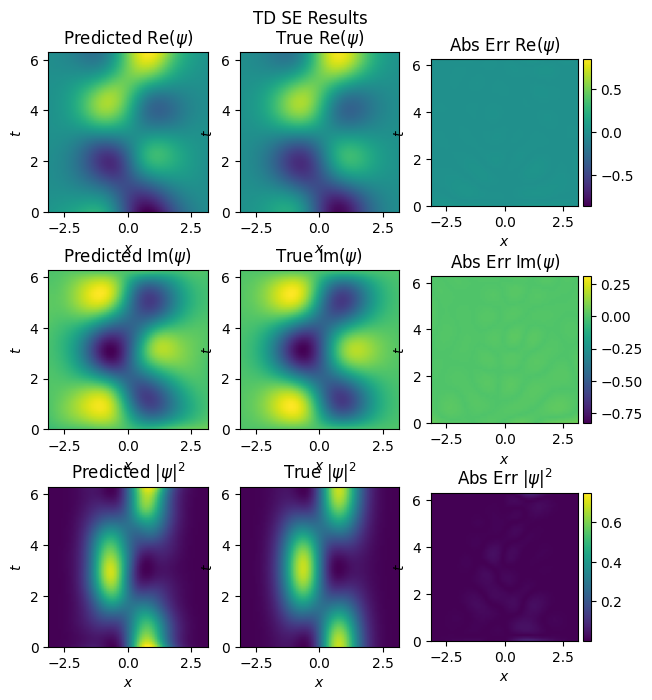

mse: u: 0.00010752771343785201, v:0.00010748260573661646


In [74]:
L = float(np.pi)
omega = 1
delta_T = 0.1
delta_X = 0.1
    
n_x = np.shape(np.arange(x_dom[0], x_dom[1], delta_X))[0]
n_t = np.shape(np.arange(t_dom[0], t_dom[1], delta_T))[0]

inference(model_nn, test_x, test_y, n_x, n_t, x_dom, t_dom, omega, 'nn')

Reading these snapshot plots: 
The first column consists of plots of neural network predictions The second column consists of true values and the last column is the Absolute Error between ground truth and predictions.

The rows are real($\psi$), imaginary($\psi$) and density $|\psi|^2$ .

In this case, since we used all the data over the domain for training, we get great results, where the NN approximates $\psi$ very well.

Now for a more realistic case. We might not have a lot of experimental data covering the entire domain of a system. To approximate that, let's train a neural network on a low resolution grid in a reduced domain $x \in [-\pi/4,\pi/4]$.

In [75]:
# Generate reduced training set
L = float(np.pi)
omega = 1

delta_T = 0.1
delta_X = 0.1
x_dom = [-L/4,L/4]
t_dom = [0, 2*L]

train_x, train_y = get_data_set(x_dom, t_dom, delta_X, delta_T, omega, get_analytical_solution_base)

We will test it's performance on a high resolution grid across the entire domain

In [76]:
delta_T = 0.01
delta_X = 0.01
x_dom = [-L,L]
t_dom = [0, 2*L]

test_x, test_y = get_data_set(x_dom, t_dom, delta_X, delta_T, omega, get_analytical_solution_base)

In [77]:

torch.manual_seed(314)
activation =  nn.Tanh()

model_nn = NN(2,2,20,3,activation).to(device)
n_epochs = 10000

    

In [78]:
%%time
model_nn, loss_list = train_nn(model_nn, n_epochs, train_x, train_y,)

Epoch 	 Loss
499 0.0280495968496817
999 0.009690420348012766
1499 0.002138187328487201
1999 0.0010539041688532023
2499 0.0006480188367960882
2999 0.0004383058659488573
3499 0.0003361657476766466
3999 0.00027129779263142527
4499 0.0006277442880550771
4999 0.0001859823472012481
5499 0.00015291338629913438
5999 0.00012775851488639698
6499 0.00011071085829663684
6999 0.0003028366196810422
7499 0.00025020218896733504
7999 6.851536886864664e-05
8499 0.0006968533175957446
8999 6.234750123461479e-05
9499 5.06971087803799e-05
9999 4.505391903343265e-05
CPU times: user 56.6 s, sys: 11.7 s, total: 1min 8s
Wall time: 9.61 s


So far so good, the training loss is small. But across the entire domain, the loss is:

In [79]:
y_pred = get_model_error(model_nn, test_x, test_y)

Model loss: 
 loss_u = 0.27843895074674907 
 loss_v = 0.5049001767812281 
 loss_dens = 3.959586184871224


The error is orders of magnitude higher than our data point values! Let's look at the plots:


0 finished
1 finished
2 finished


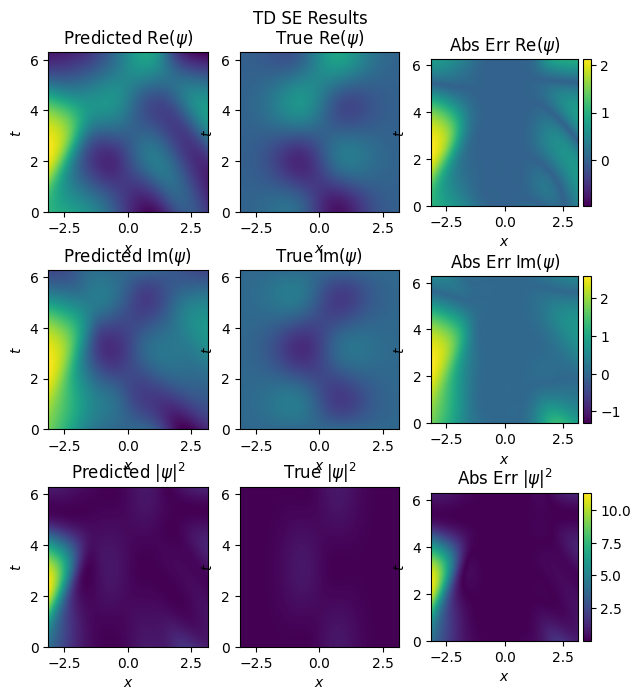

mse: u: 0.27843895074674907, v:0.5049001767812281


In [80]:
L = float(np.pi)
omega = 1
delta_T = 0.01
delta_X = 0.01
    
n_x = np.shape(np.arange(x_dom[0], x_dom[1], delta_X))[0]
n_t = np.shape(np.arange(t_dom[0], t_dom[1], delta_T))[0]

inference(model_nn, test_x, test_y, n_x, n_t, x_dom, t_dom, omega, 'nn_reduced')

The values are similar in the domain that we trained on $x \in [-0.78,0.78]$ but diverge considerably near the boundaries.

To tackle this problem, we will add some information about the governing equation in the neural network.

### <span style="color:LightGreen">Physics-Informed Neural Network

Physics Informed Neural Networks are constructed by encoding the constraints posed by a given differential equation and its boundary conditions into the loss function of a Fully Connected Network. This constraint guides the network to approximate the solution of the differential equation.

For a system $f$, with solution $u(\mathbf{x},t)$, governed by the following equation

$$ \Large
f(u) = u_{t}+\mathcal{N}[u;\lambda], ~~~\mathbf{x} \in \Omega, t \in [0,T] \\
f(u) = 0 ~~~~~~~~~~~~~ \rm{otherwise}
$$

where $\mathcal{N}[u;\lambda]$ is a differential operator parameterised by $ \lambda $, $ \Omega \in \mathbb{R^D} $, $ \mathbf{x} = (x_1,x_2,...,x_d) $ with boundary conditions 

$$ \Large
\mathcal{B}(u, \mathbf{x},t)=0 \quad \text { on } \quad \partial \Omega
$$

and initial conditions

$$ \Large
\mathcal{T}(u, \mathbf{x},t)=0 \quad \text { at } \quad t = 0
$$

![PINN architecture](https://github.com/GDS-Education-Community-of-Practice/DSECOP/blob/main/Learning_the_Schrodinger_Equation/res/fig/PINN_diagrams.png?raw=1)

A neural network $u_{net}: \mathbb{R}^{D+1}\mapsto \mathbb{R}^{1}$ is constructed as a surrogate model for the true solution $u$, 

$$ \Large
f_{net}=f(u_{net})
$$

The constraints imposed by the system are encoded in the loss term $L$ for neural network optimisation

$$ \Large
L={\color{green} L_{f}}+{\color{red} L_{BC}}+{\color{blue} L_{IC}}
$$

where $L_{f}$ denotes the error in the solution within the interior points of the system, enforcing the PDE. This error is calculated for $N_f$ collocation points.

$$ \Large
\color{green} 
L_{f}=\frac{1}{N_{f}} \sum_{i=1}^{N_{f}}\left|f_{net}\left(\mathbf{x}_{f}^{i}, t_{f}^{i}\right)\right|^{2}
$$

$$ \Large
\color{red} 
L_{BC}=\frac{1}{N_{BC}} \sum_{i=1}^{N_{BC}}\left|u\left(\mathbf{x}_{BC}^{i}, t_{BC}^{i}\right)-u^{i}\right|^{2}
$$

$$ \Large
\color{blue} 
L_{IC}=\frac{1}{N_{IC}} \sum_{i=1}^{N_{IC}}\left|u\left(\mathbf{x}_{IC}^{i}, t_{IC}^{i}\right)-u^{i}\right|^{2}
$$

$L_{BC}$ and $L_{IC}$ represent the constraints imposed by the boundary and initial conditions, calculated on a set of $N_{BC}$ boundary points and $N_{IC}$ initial points respectively, with $u_i$ being the ground truth.

<img src="https://github.com/GDS-Education-Community-of-Practice/DSECOP/blob/main/Learning_the_Schrodinger_Equation/res/fig/colloc_points.png?raw=1" alt="Domain" width="400"/>

Once sufficiently trained, the network can be used as a solver for the PDE, potentially for a range of parameters $ \lambda $.


Since PINNs can be used to solve systems of arbitrary resolutions once they are trained and generalise well over different parameter spaces, they might be used to accelerate the solution of PDEs. 

The following function creates the collocation points for the equation, boundary and initial conditions.



In [81]:
def get_physics_colloc_points(x_dom, t_dom, delta_X, delta_T,analytical_solution_function):

    x = np.arange(x_dom[0], x_dom[1], delta_X).astype(float)
    t = np.arange(t_dom[0], t_dom[1], delta_T).astype(float)
    X, T = np.meshgrid(x, t)
    
    x_physics = np.expand_dims(X.flatten(), axis=-1)
    t_physics = np.expand_dims(T.flatten(), axis=-1)

    x_physics = torch.tensor(x_physics).requires_grad_(True).to(device)
    t_physics = torch.tensor(t_physics).requires_grad_(True).to(device)

    f_colloc = torch.hstack((x_physics, t_physics)).to(device)
    
    t_ic = np.zeros_like(x)
    X_ic, T_ic = np.meshgrid(x, t_ic)
    
    x_ic = np.expand_dims(X_ic.flatten(), axis=-1)
    t_ic = np.expand_dims(T_ic.flatten(), axis=-1)
    
    ic_sol = analytical_solution_function(x_ic,t_ic, omega)
    ic = np.hstack((np.real(ic_sol), np.imag(ic_sol)))
    
    ic = torch.tensor(ic).requires_grad_(False).to(device)
    
    x_ic = torch.tensor(x_ic).requires_grad_(False).to(device)
    t_ic = torch.tensor(t_ic).requires_grad_(False).to(device)

    ic_colloc = torch.hstack((x_ic, t_ic))
    
    x_b = np.array(x_dom)
    X_b, T_b = np.meshgrid(x_b, t)
    x_b = np.expand_dims(X_b.flatten(), axis=-1)
    t_b = np.expand_dims(T_b.flatten(), axis=-1)

    x_b = torch.tensor(x_b).requires_grad_(False).to(device)
    t_b = torch.tensor(t_b).requires_grad_(False).to(device)

    b_colloc = torch.hstack((x_b, t_b))
    
    return x_physics, t_physics,f_colloc, b_colloc, ic_colloc, ic

omega = 1
x_dom = [-L,L]
t_dom = [0,2*L]
delta_x = 0.2
delta_t = 0.2
analytical_solution_function = get_analytical_solution_base
x_physics, t_physics, f_colloc, b_colloc, ic_colloc, ic = get_physics_colloc_points(x_dom, t_dom, delta_x, delta_t, analytical_solution_function)

___<span style="color:Violet">Exercise</span>___: What will the loss terms look like in this case? 

Hint: Split the Schrodinger equation in real and imaginary parts to calculate the equation loss.

Solution: The time-dependent Schrödinger equation can be written as

$$ \Large
    \left(-\frac{\partial v}{\partial t}+\frac{1}{2}\frac{\partial^{2} u}{\partial x^{2}}-\frac{\omega^{2}}{2}x^{2}\right) + i \left(\frac{\partial u}{\partial t}+\frac{1}{2}\frac{\partial^{2} v}{\partial x^{2}}-\frac{\omega^{2}}{2}x^{2}\right) = 0
$$

The loss function $L$ is given by 

$$ \Large
L=L_{f}+L_{BC}+L_{IC}
$$

$$ \Large
L_{BC}=\frac{1}{N_{BC}} \sum_{i=1}^{N_{BC}}\left(\left|u\left(\mathbf{r}_{BC}^{i}, t_{BC}^{i}\right)-u^{i}\right|^{2}+\left|v\left(\mathbf{r}_{BC}^{i}, t_{BC}^{i}\right)-v^{i}\right|^{2}\right)
$$

$$ \Large
L_{IC}=\frac{1}{N_{IC}} \sum_{i=1}^{N_{IC}}\left(\left|v\left(\mathbf{r}_{IC}^{i}, t_{IC}^{i}\right)-u^{i}\right|^{2}+\left|v\left(\mathbf{r}_{IC}^{i}, t_{IC}^{i}\right)-v^{i}\right|^{2}\right)
$$

$$ \Large
L_{f}=\frac{1}{N_{f}} \sum_{i=1}^{N_{f}}\left|f_{net}\left(\mathbf{r}_{f}^{i}, t_{f}^{i}\right)\right|^{2}
$$

At each training step, the loss function is calculated on $N_f$ collocation points, sampled randomly from the grid.

We need to modify the training loop to calculate the new physics informed loss function:

In [82]:
def train_pinn(model, n_epochs, train_x, train_y, x_physics, t_physics, f_colloc, b_colloc, ic_colloc, ic):
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
    loss_list = np.zeros(n_epochs)
    print("Epoch \t Loss \t PDE Loss")
    for i in range(n_epochs):
        optimizer.zero_grad()
        y_pred = model(train_x)

        loss1 = torch.mean((y_pred-train_y)**2)

        # calculate loss on colloc points

        y_pred = model(f_colloc)

        u = y_pred[:,0]
        v = y_pred[:,1]

        du_dx  = torch.autograd.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]
        du_dxx  = torch.autograd.grad(du_dx, x_physics, torch.ones_like(du_dx), create_graph=True)[0]
        du_dt = torch.autograd.grad(u,  t_physics, torch.ones_like(y_pred[:,0]),  create_graph=True)[0]
        if debug:
            print("flag_2")
        dv_dx  = torch.autograd.grad(v, x_physics, torch.ones_like(v), create_graph=True)[0]
        dv_dxx  = torch.autograd.grad(dv_dx, x_physics, torch.ones_like(dv_dx), create_graph=True)[0]
        dv_dt = torch.autograd.grad(v,  t_physics, torch.ones_like(v),  create_graph=True)[0]
        if debug:
            print("flag_3")
        loss_u = -du_dt - 1/2 * (dv_dxx + omega**2/2 * x_physics**2) * v.view(-1,1)
        loss_v = -dv_dt + 1/2 * (du_dxx + omega**2/2 * x_physics**2) * u.view(-1,1)

        loss_physics = torch.stack((loss_u, loss_v))
        if debug:
            print("flag_4")
        y_pred_b = model(b_colloc)
        y_pred_ic = model(ic_colloc)
        if debug:
            print("flag_5")
        loss_b = torch.mean(y_pred_b**2)
        loss_ic = torch.mean((y_pred_ic - ic)**2)

        loss2 =  (torch.mean(loss_physics**2) + loss_b + loss_ic)
        if debug:
            print("flag_6")
        

        loss = loss1 + (1e-4) * loss2# add two loss terms together
        loss_list[i] = loss.detach().cpu().numpy()

        loss.backward()
        optimizer.step()
        if debug:
            print("flag_7")
        if i % 500 == 499:
            print(f"{i} {loss} {loss2}")
    
    return model, loss_list

We will now train the PINN on the same reduced domain

In [83]:

debug = False
torch.manual_seed(123)
activation =  nn.Tanh()

n_epochs = 10000
model_pinn = NN(2,2,32,3,activation).to(device)
model_pinn, loss_pinn = train_pinn(model_pinn, n_epochs, train_x, train_y, x_physics, t_physics, f_colloc, b_colloc, ic_colloc, ic)

Epoch 	 Loss 	 PDE Loss
499 0.014588414251169458 0.5443244929559576
999 0.0020570294161056523 0.4798914731997963
1499 0.0007510534236043466 0.3206896225661473
1999 0.00039025409281648375 0.2743827609589016
2499 0.0002352930945909385 0.2565677862193554
2999 0.00015686196706198008 0.2478984727216319
3499 0.00011534335880468258 0.24316524694599004
3999 0.00026287114203943807 0.23552571614393783
4499 8.460051347531427e-05 0.22853465243318152
4999 7.879858460994293e-05 0.22003044519985812
5499 6.06124125286827e-05 0.2148690466689354
5999 0.00011716101862730677 0.2079739738894505
6499 6.970775526306723e-05 0.20501915340643292
6999 4.6419685141038864e-05 0.2009047493338139
7499 4.417519016271358e-05 0.19728154943524615
7999 4.1270563617775325e-05 0.19497542651932778
8499 4.0412979996635944e-05 0.19194412689085263
8999 3.731735901610303e-05 0.19049675059561139
9499 3.704126578130983e-05 0.1880710380417881
9999 3.4215836758528444e-05 0.18686385961028093


In [84]:
y_pred = get_model_error(model_pinn, test_x, test_y)

Model loss: 
 loss_u = 0.0051744012806154704 
 loss_v = 0.004228406481830343 
 loss_dens = 0.00108018392215922


0 finished
1 finished
2 finished


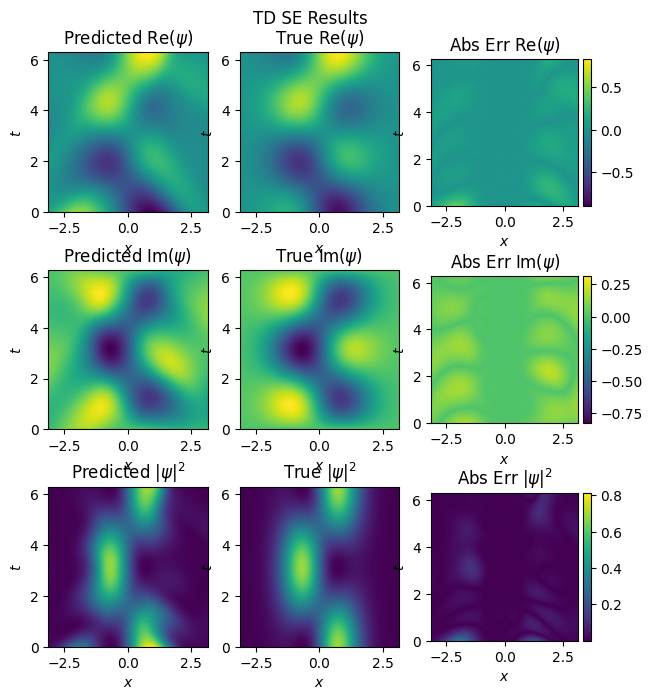

mse: u: 0.005174401280615469, v:0.004228406481830342


In [85]:
L = float(np.pi)
omega = 1
delta_T = 0.01
delta_X = 0.01
    
n_x = np.shape(np.arange(x_dom[0], x_dom[1], delta_X))[0]
n_t = np.shape(np.arange(t_dom[0], t_dom[1], delta_T))[0]

inference(model_pinn, test_x, test_y, n_x, n_t, x_dom, t_dom, omega, 'pinn_reduced')

The PINN model matches the system well, even when trained on reduced data.

#### <span style="color:Orange">Training Considerations</span>

##### <span style="color:Violet">Architecture</span>

The architecture and associated hyperparameters have significant impact on the performance of the PINN. The learning model architecture can be customized depending on the nature of the domain. For example, CNNs, RNNs and GNNs can be used for spatial, temporal and interacting problems respectively. For the one-dimensional quantum harmonic oscillator workflow, we use a FCN with 3 layers of 20 neurons each. 

Optimizer selection is important for convergence of the learner and to avoid solutions at local minima. It has been shown that a combination of Adam  at early training and L-BFGS for later stages has been effective for solving a variety of PDEs through PINNs. We use the Adam optimizer only given the relatively simple nature of this problem.

___<span style="color:Violet">Exercise</span>___: Try running the PINN with ReLU activation function. What are your observations? Why would this activation function not work?

Solution: As we saw in calculating the residual, the choice of activation functions is constrained by the fact that they have to be $(n+1)$-differentiable for $n$-order PDEs. For the one-dimensional quantum harmonic oscillator problem we use $\tanh$ activation functions because they are 3-differentiable.

##### <span style="color:Violet">Collection Points</span>


The accuracy of the NN increases with increase in density of collocation points. However, the computational resources required also increases exponentially with the increase in density of points. This can lead to training bottlenecks, especially for high dimensional systems. A trade-off has to be made between the desired accuracy and number of collocation points because training the NN on a large number of points may lead to overfitting and adversely affect generalisability. The distribution of points can also be customised according to the problem domain. Density could be increased around areas of sharp discontinuities to capture more information about the domain. 

___<span style="color:Violet">Exercise</span>___: What is the effect of changing collocation points on the training time and accuracy of the Neural Network? You can run it multiple times with different grids of collocation point to observe this.

Solution

Training time and accuracy both increase exponentially with collocation grid size.

<img src="https://raw.githubusercontent.com/GDS-Education-Community-of-Practice/DSECOP/main/Learning_the_Schrodinger_Equation/res/fig/pinn_colloc_time.png" alt="Domain" width="400"/>

<img src="https://raw.githubusercontent.com/GDS-Education-Community-of-Practice/DSECOP/main/Learning_the_Schrodinger_Equation/res/fig/pinn_colloc_performance.png" alt="Domain" width="400"/>

---


## <span style="color:Orange">Higher Energy States</span>

We will now check the performance of NNs on systems with higher energy states. For demonstration, the system used is $\psi_{1,3}(x,t)$.  The analytic solution is implemented in the method below (I will leave it to you to derive it)

Let's write some code to compute it for arbitrary values of $x,t,\omega$

In [86]:
def get_analytical_solution_1_3(X,T, omega):
    #Solution:
    phi_0 =(omega / np.pi) ** (1. / 4.) * np.exp(-X * omega * X / 2.0)
    phi_1 = phi_0 *  np.sqrt(omega / 2.) * 2.0 * X
    phi_3 = phi_0 * 1/np.sqrt(48) * (8. * omega**(3./2.) * X**3. - 12. * omega**(1./2.) * X)
    psi = np.sqrt(1. / 2.) * (np.exp(-1j * 3./2. * omega * T) * phi_1 + np.exp(-1j * 7./2. * omega * T) * phi_3)

    return psi

You can explore the system here:

<img src="https://github.com/GDS-Education-Community-of-Practice/DSECOP/blob/main/Learning_the_Schrodinger_Equation/res/plots/waveform/psi_1_3/animation.gif?raw=true" width=800 align=left></img><br>

Using a reduced grid with Fully Connected Network, we have

In [87]:
L = float(np.pi)
omega = 1

delta_T = 0.1
delta_X = 0.1
x_dom = [-L/4,L/4]
t_dom = [0, 2*L]

train_x, train_y = get_data_set(x_dom, t_dom, delta_X, delta_T, omega, get_analytical_solution_1_3)

In [88]:
delta_T = 0.01
delta_X = 0.01
x_dom = [-L,L]
t_dom = [0, 2*L]

test_x, test_y = get_data_set(x_dom, t_dom, delta_X, delta_T, omega, get_analytical_solution_1_3)

In [89]:


torch.manual_seed(314)
activation =  nn.Tanh()

model_nn_he = NN(2,2,32,3,activation).to(device)
optimizer = torch.optim.Adam(model_nn_he.parameters(),lr=1e-3)

n_epochs = 10000

In [90]:
%%time
model_nn_he, loss_list = train_nn(model_nn_he, n_epochs, train_x, train_y)
    

Epoch 	 Loss
499 0.034809462864400655
999 0.030770489596605062
1499 0.029024043489032685
1999 0.027544662523820984
2499 0.02454030788261396
2999 0.01883289422806623
3499 0.015966129543422993
3999 0.01346336538451275
4499 0.008211637550135972
4999 0.004168400301328305
5499 0.002861152901053209
5999 0.002148471355688253
6499 0.0016391422117425726
6999 0.0012603079317693774
7499 0.0010119188302159033
7999 0.0008375657759298641
8499 0.0007156548786497773
8999 0.0006314462618038756
9499 0.0005685116818783471
9999 0.0005134273900135653
CPU times: user 50.1 s, sys: 9.8 s, total: 59.9 s
Wall time: 7.76 s


In [91]:
y_pred = get_model_error(model_nn_he, test_x, test_y)

Model loss: 
 loss_u = 0.21186591749405562 
 loss_v = 0.337094501740013 
 loss_dens = 1.1886924241876031


0 finished
1 finished
2 finished


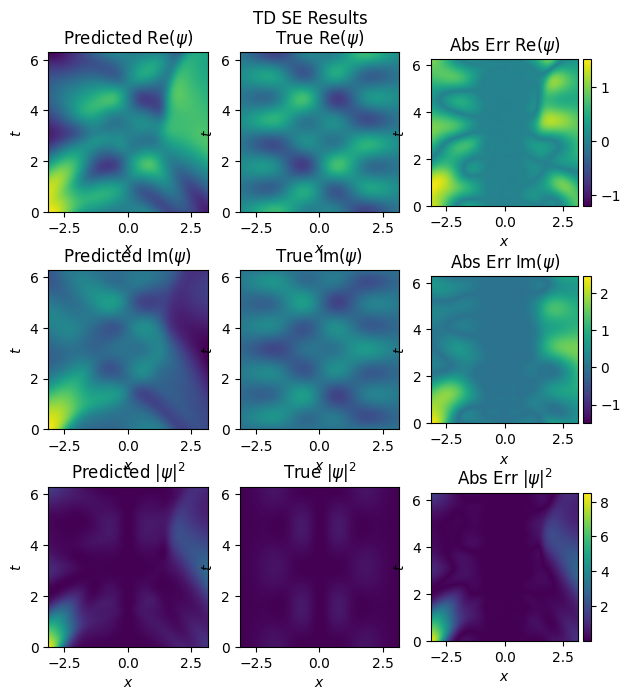

mse: u: 0.2118659174940555, v:0.33709450174001304


In [92]:
L = float(np.pi)
omega = 1
delta_T = 0.01
delta_X = 0.01
    
n_x = np.shape(np.arange(x_dom[0], x_dom[1], delta_X))[0]
n_t = np.shape(np.arange(t_dom[0], t_dom[1], delta_T))[0]

inference(model_nn_he, test_x, test_y, n_x, n_t, x_dom, t_dom, omega, 'high_nn')

This does not capture any detail beyond the domain, as seen in Abs Err plots. Now for PINNs:

In [93]:
omega = 1
x_dom = [-L,L]
t_dom = [0,2*L]
delta_x = 0.2
delta_t = 0.2
analytical_solution_function = get_analytical_solution_1_3
x_physics, t_physics, f_colloc, b_colloc, ic_colloc, ic = get_physics_colloc_points(x_dom, t_dom, delta_x, delta_t, analytical_solution_function)

In [94]:
debug = False
torch.manual_seed(314)
activation =  nn.Tanh()

n_epochs = 10000
model_pinn_he = NN(2,2,32,3,activation).to(device)



In [95]:
model_pinn_he, loss_pinn = train_pinn(model_pinn_he, n_epochs, train_x, train_y, x_physics, t_physics, f_colloc, b_colloc, ic_colloc, ic)

Epoch 	 Loss 	 PDE Loss
499 0.034803315397587825 1.1667250222004513
999 0.030816239251446303 0.892797702973085
1499 0.02898433086983385 0.8024795782817108
1999 0.02725238837113853 0.6911578046300655
2499 0.023496802156767044 0.6376621529324935
2999 0.01785216152448554 0.7411634771480853
3499 0.01463447300759326 0.8827789913655322
3999 0.011158598100972996 0.9597367131439621
4499 0.005115866649541363 1.1235537627506296
4999 0.0032234724772463503 1.1962402635031897
5499 0.0023450706079219535 1.1992541127715377
5999 0.0018094441197075322 1.0795630597511812
6499 0.0014278926536830082 0.9309726743353068
6999 0.0011448157141342621 0.8065568939649282
7499 0.0009412202058604413 0.7363376590987324
7999 0.0007830939508753171 0.6778500614880502
8499 0.0006669308950099964 0.6088177919967184
8999 0.0005860917440631878 0.5667642032426455
9499 0.0005240070592658164 0.5358619219047838
9999 0.0006053468956952364 0.5066755423420649


In [96]:
y_pred = get_model_error(model_pinn_he, test_x, test_y)

Model loss: 
 loss_u = 0.06425666320760758 
 loss_v = 0.039329193917649226 
 loss_dens = 0.013390438650537394


In [97]:
L = float(np.pi)
omega = 1
delta_T = 0.01
delta_X = 0.01
    
n_x = np.shape(np.arange(x_dom[0], x_dom[1], delta_X))[0]
n_t = np.shape(np.arange(t_dom[0], t_dom[1], delta_T))[0]
test_x, test_y = get_data_set(x_dom, t_dom, delta_X, delta_T, omega, get_analytical_solution_1_3)

0 finished
1 finished
2 finished


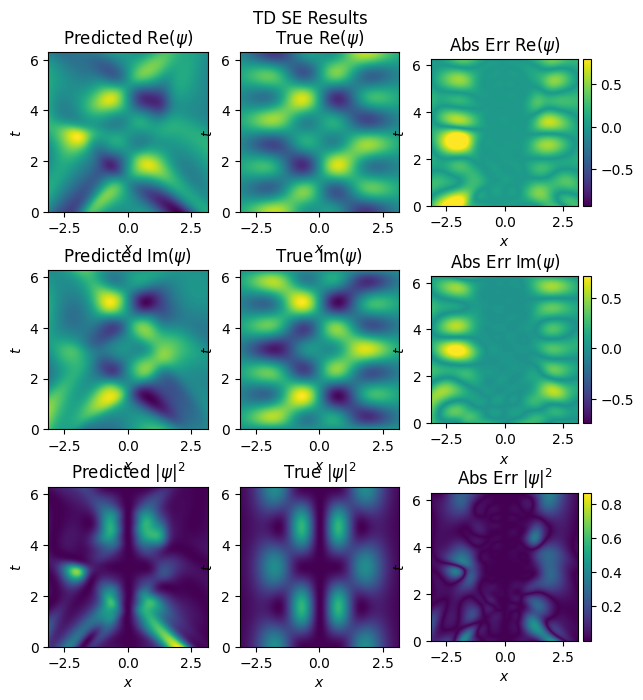

mse: u: 0.06425666320760758, v:0.039329193917649226


In [98]:
inference(model_pinn_he, test_x, test_y, n_x, n_t, x_dom, t_dom, omega, 'high_pinn')

For higher energy states, it is difficult to capture the details with fully connected layers. PINNs can be extended with Recurrent Neural Networks to tackle this.

## <span style="color:Orange">Some Project Ideas</span>

1. Experiment with different layer types for the higher energy states. One particular layer that might be useful would be gru layer (https://pytorch.org/docs/stable/generated/torch.nn.GRU.html). These layers are used for time series forecasting in Recurrent Neural Networks, which might be helpful for our time dependent system.

2. You can also use causal training loss for the higer energy states. The loss we have been using so far does not take causality into account. For a causal loss function, we divide the domain into consecutive time chunks and use a weighted sum of losses that enforces order in time. You can read more about it here: 

2. Modify the PINNs to work with 2D QHO system
Hint: Since this is a separable system, we can extend it to 2D as follow:
$$ \Large
\phi_n = \phi_n(x)\phi_n(y)
$$

$$ \Large
\hat{H} =\hat{H_x}+\hat{H_y}
$$

3. Can the neural network generalize over other parameters as well? Add $\omega$ as an input to the neural network and train it to work with a range of $\omega$ values.

4. Implement this network for other systems such as infinite square well.

## <span style="color:Orange">Acknowledgments</span>

* Initial version: Mark Neubauer
  * From APS GDS repository

© Copyright 2025